<a href="https://colab.research.google.com/github/majidraeis/MultiStage/blob/master/TandemQueue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-set Generation for Tandem Multi-server Queues

![alt text](https://raw.githubusercontent.com/majidraeis/Figs/master/queue.png)

The first part of this notebook introduces the process of data-set generation for waiting-time analysis in tandem queues with multi-server stations.  The queueing network topology (# of stages and # of servers per stage), as well as customer arrival and service times are the inputs which should be given to the model to generate the dataset. In fact, we generate $N_{sample}$ customers (jobs, passengers, $\cdots$) and track them through the system to compute the required features for each customer. Therefore, each customer is associated with an arrival time and $N_{stage}$ service times for each stage of the system, for e.g.

Customer ID | $t_a$| $t_s^1$ | $t_s^2$ |  $\cdots$ | $t_s^{N_{stage}}$
 --- | --- | --- | --- | --- | ---|
1 | 0.02 | 1.1 | 3.4 | $\cdots$ | 0.8 
2 | 0.95 | 0.1 | 6.3 | $\cdots$ | 4.3 
...

where $t_a$ represents arrival time and $t_s^i$ represents the experienced service time at stage $i$.

The arrival and service processes can be either generated (using different distributions) or fed from real data sets. 

We start with defining the single stage queue function. 




In [0]:
import os
import csv
import argparse
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib, csv, copy
from matplotlib import cm
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, model_from_json
from keras.engine.topology import Layer
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
from scipy.stats import norm, gamma, gaussian_kde, skewnorm, expon
from __future__ import absolute_import, division, print_function
from tensorflow.python.keras.callbacks import TensorBoard
from scipy.optimize import minimize, minimize_scalar
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
from scipy.optimize import fsolve


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Single-Stage Multi-server Queue as a Building Block

The inputs and output are as follows:

* **Inputs**
 * Arrival times $({T_a})_{N_{sample}\times 1}$
 * Service times $({T_s})_{N_{sample}\times 1}$
 * Number of servers ($N$)
* **Outputs**
 *  Departure times $({T_d})_{N_{sample}\times 1}$
 * Waiting times $({T_w})_{N_{sample}\times 1}$, defined as $T_w^i = T_d^i - T_a^i - T_s^i$ for customer $i$ 
 * Backlog process $B_{2N_{sample}\times 3}$, 
   \[time stamp (arrival or departure), # customers in the queue, # customers in the system (queue+servers)\]

In [0]:
class Job:
    def __init__(self, Ta, Ts, index):
        length = np.size(Ta)
        Td = np.zeros(length)
        Tw = np.zeros(length)
        Ba = np.zeros(length)
        Dict = {}
        for i in range(len(Ta)):
            Dict[index[i]]= {'Ta':Ta[i], 'Td':Td[i], 'Ts':Ts[i],
                             'Tw':Tw[i], 'Ba':Ba[i]}
        
        self.dict = Dict
        #Dictionary values:  1-ArrivalTime 2-DepartureTime 
        #3-ServiceTime 4-WaitingTime 5-BackloggUponArrival 
def MultiServQueue(job, N):
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    length = len(jobIndex)
    order = np.argsort(np.array([f['Ta'] for f in jobMatrix]).flatten())
    Ta = np.array([f['Ta'] for f in jobMatrix])[order]
    Ts = np.array([f['Ts'] for f in jobMatrix])[order]
    jobIndexOrdered = jobIndex[order]
    indexout = []
    f = Ta[0:N] + Ts[0:N]
    les_f = Ta[0:N]
    d = sorted(f)
    e = sorted(les_f)
    index = jobIndexOrdered[np.argsort(f)]
    backlogD = [[0, 0, 0]]
    backlogA = []
    jobDepCum = []

    for i in tqdm(range(0, length)):
        JobDep, d = d[0], np.delete(d, 0)
        indexout = np.append(indexout, index[0])
        index = np.delete(index, 0)

        jobDepCum.append(JobDep)

        tempOcc = float(np.sum(Ta <= JobDep) - (i + 1))
        backlogD.append([JobDep, max(tempOcc - N, 0.0), tempOcc])
        tempOcc = float(i + 1 - np.sum(jobDepCum <= Ta[i]))
        backlogA.append([Ta[i], max(tempOcc - N, 0.0), tempOcc])
        job.dict[jobIndex[i]]['Ba'] = np.round(max(i - np.sum(jobDepCum 
                                                              <= Ta[i]), 0))
        # num of customors in the system (including servers)
        # right upon i'th arrival

        if i <= length - N - 1:
            F = max(Ta[N + i], JobDep) + Ts[N + i]
            u = np.append(F, d)
            u = np.maximum(u, F)
            addedIndex = np.sum(u == F) - 1
            d = np.minimum(np.append(d, np.inf), u)
            index = np.append(index[:addedIndex], 
                    np.append(jobIndexOrdered[N + i], index[addedIndex:]))

        job.dict[indexout[-1]]['Td'] = JobDep
        #job.dict[indexout[-1]][3]= 
        #max(0 , JobDep - job.dict[indexout[-1]][0]) # delay (Sojourn)
        job.dict[indexout[-1]]['Tw'] = max(0.0, JobDep 
               - job.dict[indexout[-1]]['Ta'] 
               - job.dict[indexout[-1]]['Ts'])  # waiting

    backlogA = np.concatenate((backlogA, backlogD))
    backlogA = np.array(sorted(backlogA, key=lambda x: x[0]))
    job.Backlog = backlogA


## Defining Arrival and Service Generating Functions

Here we define the following arrival and service processes:

* **Arrival**
 * Poisson
 * Hyper-exponential (H2)
 
 * Markov-ON-OFF 
 * Deterministic-ON-OFF
 * Non-homogeneous Poisson Process (Time-variant process)
   * https://web.ics.purdue.edu/~pasupath/PAPERS/2011pasB.pdf
* **Service** 
 * Exponential
 * Log-normal

In [0]:
def MarkovOnOff(length, Alpha, Beta, Lambda): 
  # Alpha = off-> on | Beta = on -> off
    s = 1
    interArr = np.zeros(length)
    i = 0
    while i < length:

        state_stay = np.random.exponential(1 / Beta)
        elapsed_time = 0
        while s and i < length:
            temp = np.random.exponential(1/Lambda)
            elapsed_time = elapsed_time + temp
            if elapsed_time < state_stay:
                interArr[i] = interArr[i] + temp
                i += 1
            else:
                interArr[i] = interArr[i] + state_stay - (elapsed_time - temp)
                s = 0
        if not s and i < length:
            state_stay = np.random.exponential(1 / Alpha)
            interArr[i] = interArr[i] + state_stay
            s = 1
    Ta = np.cumsum(interArr)
    return Ta

def DetOnOff(length, Ton, Toff, Ta_ON):
    Num_ON = int(Ton/Ta_ON)
    Num_OFF = int(Toff/Ta_ON)
    inter_arr = []
    i = 0
    while i < length-Num_ON:
            inter_arr = np.append(inter_arr, Ta_ON * np.ones(Num_ON-1))
            inter_arr = np.append(inter_arr, Ta_ON * Num_OFF)
            i += Num_ON
    inter_arr = np.append(inter_arr, Ta_ON * np.ones(length-i))
    Ta = np.cumsum(inter_arr)
    return Ta

def NonHomPoisson(length, Lambda, lambda_u):
    Ta = []
    t = 0
    l = 0
    while l < length:
        t = t + np.random.exponential(1/lambda_u)
        if np.random.uniform(0, 1) < Lambda(t)/lambda_u:
            Ta.append(t)
            l += 1
    Ta = np.array(Ta)
    return Ta
#   ***********************************************************************
def Arrival_Gen(ArrivalType, mean_Ta, lengthTa):
    if ArrivalType == "M":
        interArr = np.random.exponential(mean_Ta, lengthTa)
        Ta = np.cumsum(interArr)

    elif ArrivalType == "H2":
        c_a = 2.0 #SCV
        p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
        p2 = 1-p1
        mu1 = 2*p1/mean_Ta
        mu2 = 2*p2/mean_Ta
        coeff1 = (np.random.uniform(0, 1, lengthTa) < p1)
        coeff2 = ~ coeff1
        interArr1 = np.random.exponential(1/mu1, lengthTa)
        interArr2 = np.random.exponential(1 / mu2, lengthTa)
        interArr = coeff1*interArr1 + coeff2*interArr2
        Ta = np.cumsum(interArr)
        
    elif ArrivalType == "Gamma":
        c_a2 = 0.7 #SCV^2
        # c_a2 = 1.5 #SCV^2
        mu = mean_Ta
        k = 1/c_a2
        theta = mu/k
        Ta = np.cumsum(np.random.gamma(k, theta, lengthTa))

    elif ArrivalType == "M_ONOFF":
        Alpha = 0.1 #off->on
        Beta = 0.4
        Lambda = N[0]*rho*(Alpha + Beta)/(Alpha * mean_Ts[0])
        Ta = MarkovOnOff(lengthTa, Alpha, Beta, Lambda)
        
    elif ArrivalType == "DetOnOff":
        T_period = day #/ 24.0  # i.e. E[s] = 5min
        ON_ratio = 0.75
        T_on = ON_ratio * T_period
        T_off = T_period - T_on
        Ta_on = mean_Ta * ON_ratio # (mean_Ts/(N*rho)) * ON_ratio
        Ta = DetOnOff(lengthTa, T_on, T_off, Ta_on)

    elif ArrivalType == 'NonHomPoisson':
        alpha = 0.5 #relative amplitude
        lambda_bar = 1 / mean_Ta
        lambda_u = lambda_bar * (1 + alpha)
        Gamma = day#cycle life
        Lambda = lambda t: lambda_bar + lambda_bar * alpha * np.sin(2*np.pi*t/Gamma)
        Ta = NonHomPoisson(lengthTa, Lambda, lambda_u)
    return Ta

def Service_Gen(ServiceType, mean_Ts, lengthTa):
    Ts = []
    if ServiceType == "M": #exponential
        Ts = np.random.exponential(mean_Ts, lengthTa)
    elif ServiceType == "logNorm":  # for lognormal service
        c_s = 1.0 #SCV
        sigma = np.log(1+c_s**2)**0.5
        mu = np.log(mean_Ts) - (sigma**2)/2.0
        Ts = np.exp(np.random.normal(mu, sigma, lengthTa))
    elif ServiceType == "Gamma":
        c_s2 = 0.8 #SCV^2
        # c_s2 = 1.2 #SCV^2
        mu = mean_Ts
        k = 1/c_s2
        theta = mu/k
        Ts = np.random.gamma(k, theta, lengthTa)
    return Ts

# Tandem Queues 
## Initialization

Pick the arrival and service time distributions, number of stages ($N_{stage}$), number of servers per stage, and specify whether to generate training or testing dataset.

In [0]:

#@title Choose Arrival and Service Processes { run: "auto" }

TrainingArrivalType = 'Gamma' #@param ["'M'", "'H2'", "'M_ONOFF'", "'DetOnOff'", "'NonHomPoisson'", "'MarkovOnOff'", "'Gamma'"] {type:"raw"}
TestArrivalType = 'Gamma' #@param ["'M'", "'H2'", "'M_ONOFF'", "'DetOnOff'", "'NonHomPoisson'", "'MarkovOnOff'", "'Gamma'"] {type:"raw"}
ServiceType = 'Gamma' #@param ["'M'", "'logNorm'", "'Gamma'"] {type:"raw"}


In [0]:
# training = 0 # set to one(zero) for generating training(test) data
training = 0
rho = 0.95
c_s2 = 0.8 #SCV^2
TotHistLength = 1
# ******************************
# N = [3,3,5,5,4,4]
# N_stage = len(N)
# mean_Ts = (3.0)*np.ones(N_stage)
# var_Ts = c_s2*mean_Ts**2 
# ******************************
c_s2 = 0.8 #SCV^2
mean_Ts = np.array([5.0, 3.0, 2.0])
var_Ts = c_s2*mean_Ts**2 
skew_Ts = 2*np.sqrt(c_s2)*np.ones(3)
N = [5, 3, 2]
N_stage = len(N)
# ******************************
mean_Ta = mean_Ts[0] / (N[0] * rho)
day = 24*6
# time_step = 24*60.0/day # Time unit (mins)
if training:
    duration = 400 * day
    ArrivalType = TrainingArrivalType
else:
    duration = 7 * day
    ArrivalType = TestArrivalType
lengthTa = int(duration / mean_Ta)
samplePathLen = int(5 * day / mean_Ta)
c_a = 2.0

gdrive_dir = '/content/gdrive/My Drive/Colab Notebooks'
training_data_directory = gdrive_dir + '/MultiStage_QLBased/%s_%s' % (TrainingArrivalType, ServiceType)
test_data_directory = gdrive_dir + '/MultiStage_QLBased/%s_%s' % (TestArrivalType, ServiceType)
if not os.path.exists(training_data_directory):
    os.makedirs(training_data_directory)
if not os.path.exists(test_data_directory):
    os.makedirs(test_data_directory)
    
fig_directory = test_data_directory + '/fig'
if not os.path.exists(fig_directory):
    os.makedirs(fig_directory)

##  Multiple Stages in tandem
* Arrival times for stage $i$ = Departure times from stage $i-1$  
* Computing end-to-end delays 

For each customer, we compute the departure and waiting times and also the number of customers at each stage (queue+servers) upon arrival and put them in "totalJobMatrix", i.e.,

>$t_a$ | $t_d^1$ | $t_w^1$ | $b^1$ |  $t_d^2$ | $t_w^2$ | $b^2$  || $\cdots$ || $t_d^{N_{stage}}$ | $t_w^{N_{stage}}$| $b^{N_{stage}}$ | 
>---- |--- | --- | --- | --- | --- | --- || --- || --- | --- | --- |
>0.02 | 1.1 | 2.4 | 5 | 3.2 | 0.4  | 12 || $\cdots$ ||  4.6| 0.3 | 3 | 
...


100%|██████████| 957/957 [00:00<00:00, 6093.60it/s]

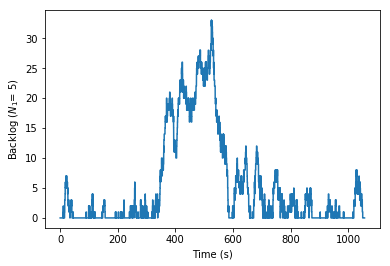


100%|██████████| 957/957 [00:00<00:00, 5526.81it/s]

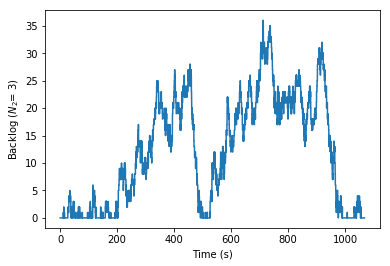


100%|██████████| 957/957 [00:00<00:00, 5359.69it/s]

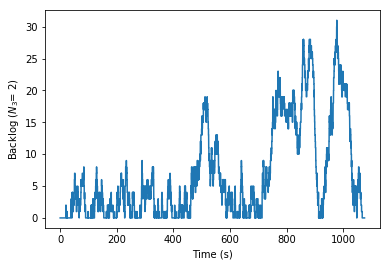

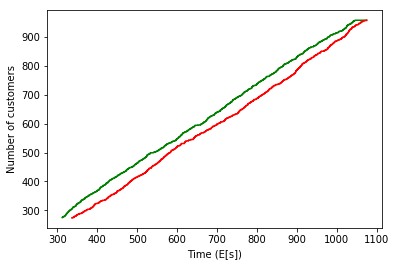

In [12]:
Ta = Arrival_Gen(ArrivalType, mean_Ta, lengthTa)
Ts = Service_Gen(ServiceType, mean_Ts[0], lengthTa)
job = Job(Ta, Ts, np.arange(1, lengthTa + 1))

for stage in range(N_stage):
    
    MultiServQueue(job, N[stage])
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    if stage > 0: 
        assert np.sum(jobIndex-jobIndexOld)==0, "The order of the jobs are not transfered correctly"
    jobIndexOld = copy.copy(jobIndex)

    arrival_time = np.array([f['Ta'] for f in jobMatrix])
    service_time = np.array([f['Ts'] for f in jobMatrix])
    waiting_time = np.array([f['Tw'] for f in jobMatrix])
    departure_time = np.array([f['Td'] for f in jobMatrix])
    backlog_uponArr = np.array([f['Ba'] for f in jobMatrix])
    
    if stage%(max(int((N_stage-1)/2),1))==0:
        plt.figure()
        plt.step(*zip(*job.Backlog[:,:2]), where='post')
        plt.ylabel('Backlog ($N_{%s}$= %s)'%(stage+1, N[stage]))
        plt.xlabel('Time (s)')
        plt.show()

    if stage==0:
        data = np.hstack((arrival_time.reshape(-1,1),
                                    np.maximum(backlog_uponArr - N[0] , 0).reshape(-1,1)))
        BacklogMatrix = copy.copy(job.Backlog[:,:2])
        
        e2eDelay = waiting_time + service_time
    else:

        BacklogMatrix = np.hstack((BacklogMatrix, job.Backlog[:,:2]))
        e2eDelay = e2eDelay + waiting_time + service_time
    
   # -----------creating job matrix for the next stage-----------------
    if stage+1 < N_stage:
        Ts = Service_Gen(ServiceType, mean_Ts[stage+1], lengthTa)
        for i in range(len(arrival_time)):
            job.dict[i+1]= {'Ta':departure_time[i],
                            'Td':0.0,'Ts':Ts[i], 'Tw':0.0, 'Ba':0.0}

X = np.append(np.append(0, data[:,0]), max(departure_time))
Y = np.append(range(0, lengthTa + 1), lengthTa)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'g',
         where='post', label='Cumalative arrival')
X = np.append(0, np.sort(departure_time))
Y = range(0, lengthTa + 1)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'r',
         where='post', label='Cumulative departure')
plt.ylabel('Number of customers')
plt.xlabel('Time (E[s])')
plt.show()    

label = np.reshape(e2eDelay,(-1, 1))


## Dataset Preperation & Saving Data

Using "totalJobMatrix", we use the number of customers at each state as the feature set. In other words, the training data-set looks like this:

Training data-set =
> customer | $b_1$ | $b_2$ | $\cdots$ | $b_{N_{stage}}$| **label = $w_{e2e}$**
> ---| --- | --- | --- | --- | ---
> 1| 10 | 35 | $\cdots$ | 5 | 2.3
> 2| 20 | 21 | $\cdots$ | 30 | 5.7

where $k_j$ is the number of customers at stage $j$, upon a new arrival.




In [0]:
order = np.argsort(data[:, 0])
data = data[order]
label = label[order]
BacklogMatrix = BacklogMatrix[:, 2:]
data_comp = []
for i in range(lengthTa):
    ta = data[i, 0]
    for stage in range(1, N_stage):
#         ------Finding backlog upon arrival at each stage --------------
        time = copy.copy(BacklogMatrix[:, 2*(stage-1)])
        data_comp.append(BacklogMatrix[time <= ta, 2*stage-1][-1])
if N_stage>1:
  data = np.hstack((data, np.reshape(data_comp, (-1, N_stage-1)), label))
else:
  data = np.hstack((data, label))
# ----------------------WRITING DATA----------------------
if training:
    with open(training_data_directory+'/DelayPredTrainingdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
else:
    with open(test_data_directory+'/DelayPredTestdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
    with open(test_data_directory+'/samplePath.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data[-samplePathLen:, :])
    csvFile.close()


# End-to-End Delay Prediction for Tandem Queues (Simple Feedforward)

## Defining some basic functions

In [0]:

def plot_history(history):
    fig = plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label='Val loss')
    plt.legend()

# Model
def build_model(learning_rate):
    model = Sequential([
        Dense(64, activation=tf.nn.relu,input_shape=(train_data.shape[1],)),
        Dense(32, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(1, activation=tf.nn.relu),
    ])
    print(model.summary())
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer)
    return model

def score(X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y_pred, y)

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


## Initialization

Choose training or prediction option, picking different ranges of learning rate, delay history length and how many steps ahead to predict.  

In [0]:
training = 0
if training:
    ArrivalType = TrainingArrivalType
else:
    ArrivalType = TestArrivalType
    
learning_rate_range = 10.0 ** -np.arange(4,  4.5, 0.5)
pred_step = 1
delayHistLength = 1
assert delayHistLength<=TotHistLength, "delayHistLength should be smaller than TotHistLength"
feature_num_stage = 1
feature_num = feature_num_stage*N_stage
batch_size = 64
Epochs = 100
directory = gdrive_dir + '/MultiStage_QLBased/Queueing_FeedForward_pred/%s_%s/stepsAhead %d'% (ArrivalType, ServiceType, pred_step)
if not os.path.exists(directory):
    os.makedirs(directory)

## Training and Test Data Preperation

Using the saved dataset, we prepare the training and test data. $T_a$ and the appended "Tot_LCS" matrix are detached for further use (plotting and comparison).

In [0]:
dataSet = np.genfromtxt(training_data_directory+'/DelayPredTrainingdata.csv'
                        , delimiter=',')  # without QLs
Ta_train = dataSet[:, 0]
dataSet = dataSet[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time, ...)
temp = np.zeros((dataSet.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = dataSet[:, k*TotHistLength:TotHistLength*(k+1)]
dataSet[:, -(feature_num * TotHistLength+1):-1] = temp
# picking a history of length #delayHistLength customers with #pred_step ahead
dataSet = np.hstack((dataSet[:, -feature_num * delayHistLength - ((pred_step-1) * feature_num + 1):
                             - ((pred_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))

testdata = np.genfromtxt(test_data_directory+'/DelayPredTestdata.csv', delimiter=',')  # with arrival times
Ta_test = testdata[:, 0]  # arrival times
testdata = testdata[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time)
temp = np.zeros((testdata.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = testdata[:, k*TotHistLength:TotHistLength*(k+1)]
testdata[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #pred_step ahead predictions
testdata = np.hstack((testdata[:, -feature_num * delayHistLength - ((pred_step-1) * feature_num + 1):
                               - ((pred_step-1) * feature_num + 1)], testdata[:, -1].reshape(-1, 1)))

samplePath = np.genfromtxt(test_data_directory+'/samplePath.csv', delimiter=',')
# preparing data for learning pairs of (delay, arrival time)
Ta_samp = samplePath[:, 0]
temp0 = samplePath[:, -(feature_num * TotHistLength+1):-1]
temp = np.zeros_like(temp0)
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = temp0[:, k*TotHistLength:TotHistLength*(k+1)]
samplePath[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #pred_step ahead predictions
samplePath = np.hstack((samplePath[:, -feature_num * delayHistLength - ((pred_step-1) * feature_num + 1):
                                   - ((pred_step-1) * feature_num + 1)], samplePath[:, -1].reshape(-1, 1)))


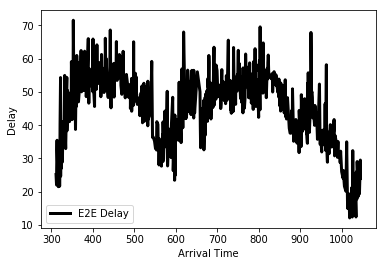

In [17]:
samplePath = np.genfromtxt(test_data_directory+'/samplePath.csv', delimiter=',')
# preparing data for learning pairs of (delay, arrival time)
Ta_samp = samplePath[:, 0]
temp0 = samplePath[:, -(feature_num * TotHistLength+1):-1]
temp = np.zeros_like(temp0)
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = temp0[:, k*TotHistLength:TotHistLength*(k+1)]
samplePath[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #pred_step ahead predictions
samplePath = np.hstack((samplePath[:, -feature_num * delayHistLength - ((pred_step-1) * feature_num + 1):
                                   - ((pred_step-1) * feature_num + 1)], samplePath[:, -1].reshape(-1, 1)))

fig = plt.figure()
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
plt.legend()
plt.xlabel('Arrival Time')
plt.ylabel('Delay')
plt.show()

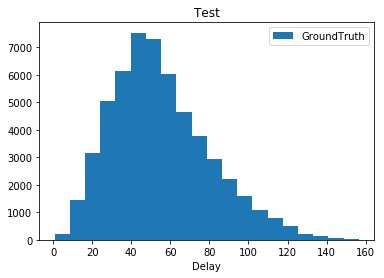

In [18]:
fig = plt.figure()
nbins = 20
plt.hist(dataSet[:, -1], nbins, label=['GroundTruth'])
plt.xlabel('Delay')
plt.legend(loc='upper right')
if training:
    plt.title('Training')
else:
    plt.title('Test')
plt.show()

In [0]:
# ///////////////////////////////Making Dataset more uniform//////////////////////

sampled_data = np.zeros((1, dataSet.shape[1]))
train_length = dataSet.shape[0]
nbins = 20
num_per_bin = 2000
bins = np.linspace(0, 200, nbins+1)
for i in range(1, nbins+1):
    temp = np.arange(dataSet.shape[0])[np.digitize(dataSet[:, -1], bins) == i]
    choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
    sampled_data = np.append(sampled_data, dataSet[choose, :], axis=0)
dataSet = sampled_data[1:, :]

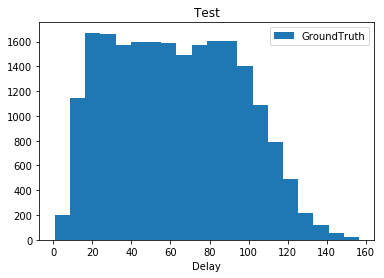

In [20]:
fig = plt.figure()
plt.hist(dataSet[:, -1], nbins, label=['GroundTruth'])
plt.xlabel('Delay')
plt.legend(loc='upper right')
if training:
    plt.title('Training')
else:
    plt.title('Test')
plt.show()

## Training and/or Prediction

In [0]:
# Shuffle the Dataset set
totSamples = np.shape(dataSet)[0]
order = np.argsort(np.random.random(totSamples))
dataSet = dataSet[order]

train_data = dataSet[:, :-1]
train_labels = dataSet[:, -1]
test_data = testdata[:, :-1]
test_labels = testdata[:, -1]

# Normalizing Features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
samplePath_inp = (samplePath[:, :-1] - mean) / std

In [22]:
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    model_directory = directory + '/model'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if training:
        model = build_model(learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model.fit(train_data, train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1,
                            verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON
        model_json = model.to_json()
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model.compile(loss='mse',
                      optimizer=tf.train.RMSPropOptimizer(learning_rate),
                      metrics=['mae'])


W0310 00:14:47.254753 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0310 00:14:47.267041 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0310 00:14:47.908396 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0310 00:14:47.909286 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0310 00:14:47.910232 140254247806848 module_wrapper.py:139] Fr

Loaded model from disk


## Plotting Groundtruth vs Predictions

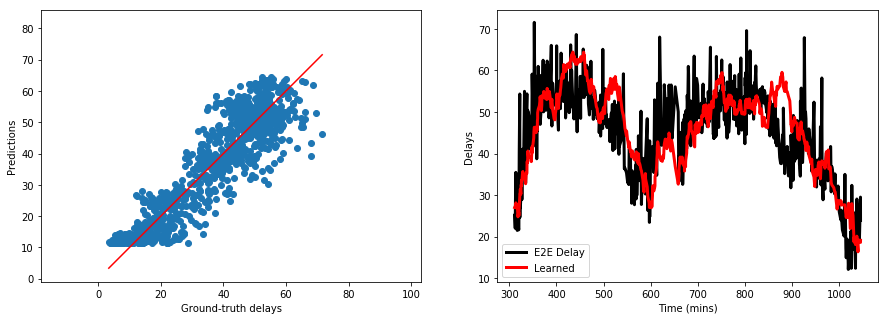

RMSE:  7.1950, Absolute Bias =  0.1272


In [23]:
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
# -----------SCATTER PLOT FOR PREDICTIOMNS-----------
test_pred = model.predict(test_data)
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# ----------------------PLOTTING A SAMPLE PATH----------------------------
samplePath_predictions = model.predict(samplePath_inp)
plt.subplot(122)
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
# ----------------------Comparing the efficiency of LES and RNN model------
AB = np.abs(np.mean(test_labels - test_pred))
RMSE = np.sqrt(mean_squared_error(test_labels, test_pred))
print("RMSE: %7.4f, Absolute Bias = %7.4f" %(RMSE, AB))

In [24]:
example = np.array([[17, 12, 17]])
example = (example - mean) / std
example_pred = model.predict(example)
print('mean = %3.2f'%example_pred)

mean = 59.88


# Predicting End-to-End Delay Distribution in Tandem Queues (MDN)
![alt text](https://raw.githubusercontent.com/majidraeis/Figs/master/mdn_feedforward.png)
Fig source: https://creativeprediction.xyz/presentations/mixture-density-networks/#/mdn-architecture

In [0]:
"""
A Mixture Density Layer for Keras
Some parts use: Charles Martin (University of Oslo) 2018
https://github.com/cpmpercussion/keras-mdn-layer
"""
def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)

class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dimension, num_mixtures, **kwargs):
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        with tf.name_scope('MDN'):
            self.mdn_mus = Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = Dense(self.num_mix * self.output_dim, 
                                    activation=elu_plus_one_plus_epsilon, name='mdn_sigmas',
                                    activity_regularizer=regularizers.l2(0.05))  # mix*output vals exp activation
            self.mdn_pi = Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x),
                                                self.mdn_sigmas(x),
                                                self.mdn_pi(x)],
                                                name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        }
        base_config = super(MDN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes], axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    with tf.name_scope('MDN'):
        return loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes], axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        return samp

    with tf.name_scope('MDNLayer'):
        return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer
    that takes one sample and compares to the true value."""
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func

def split_mixture_params(params, output_dim, num_mixes):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits

def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits. Also adjusts temperature."""
    e = np.array(w) / t  # adjust temperature
    e -= np.max(e, axis=1, keepdims=1)  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e, axis=1, keepdims=1)
    return dist

def sample_from_categorical(dist):
    """Samples from a categorical model PDF."""
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1

def sample_from_output(params, output_dim, num_mixes, length=1):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:, :num_mixes*output_dim]
    sigs = params[:, num_mixes*output_dim:2*num_mixes*output_dim]
    pis = softmax(params[:, -num_mixes:])
    m = sample_from_categorical(pis.reshape(-1,1))
    sample = np.random.normal(mus[0, m*output_dim:(m+1)*output_dim],
                              sigs[0, m*output_dim:(m+1)*output_dim],
                              size=length)
    return sample

    # //////////////////////////////////////////////////////////////////////////////////////////
def mixture_density(params, output_dim, num_mixes):
    mus = params[0, :num_mixes * output_dim]
    sigs = params[0, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(params[:, -num_mixes:])
    pis = pis[0]
    Mean = sum(mus*pis)
    Sig = np.sqrt(sum(pis*(sigs**2)))
    range_plot = np.linspace(max(0, min(mus-3*sigs)), max(mus+3*sigs), 100)
    pdf = np.zeros(len(range_plot))
    for i in range(num_mixes):
        pdf = pdf+pis[i]* norm.pdf(range_plot, mus[i], sigs[i])
    predicted_delay = Mean
    return range_plot, pdf, predicted_delay

def mixture_CDF(quantile, params, output_dim, num_mixes):
    mus = params[:, :num_mixes * output_dim].reshape(-1, 1)
    sigs = params[:, num_mixes * output_dim:2 * num_mixes * output_dim].reshape(-1, 1)
    pis = softmax(params[:, -num_mixes:]).reshape(-1, 1)
    cdf = 0
    for j in range(num_mixes):
        cdf = cdf + pis[j] * norm.cdf(quantile, mus[j], sigs[j])
    return cdf
  
def mixture_CDF_inv(prob, params, output_dim, num_mixes):
    cdf_inv=[]
    for ind,p in enumerate(prob):
      f = lambda x: mixture_CDF(x, params, output_dim, num_mixes)-p
      cdf_inv.append(fsolve(f, 40))
    return cdf_inv
  
def return_AIC(y_true, y_pred, num_mixes, output_dim, k):
    mus = y_pred[:, :num_mixes * output_dim].reshape(-1, 1)
    sigs = y_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim].reshape(-1, 1)
    pis = softmax(y_pred[:, -num_mixes:]).reshape(-1, 1)
    prob = np.zeros(len(y_true))
    for i, y in enumerate(y_true):
      for j in range(num_mixes):
         prob[i] = prob[i] + pis[j]* norm.pdf(y, mus[j], sigs[j])
        
    loglikelihood = np.sum(np.log(prob))
    AIC = 2*((3*k-1) - loglikelihood) # number of parameter = 3*k-1 (k sigma+k mus+ k-1 pi)
    return AIC

## Defining Neural Net Model

In [0]:
def build_FF_MDN_model(output_dim, num_mixes, learning_rate):
  
    OUTPUT_DIMENSION = output_dim
    NUMBER_MIXTURES = num_mixes
    model = Sequential([
    Dense(64, activation=tf.nn.relu,input_shape=(train_data.shape[1],)),
    Dense(32, activation=tf.nn.relu),
    Dense(32, activation=tf.nn.relu),
    MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES),
    ])
    model.compile(loss=get_mixture_loss_func(OUTPUT_DIMENSION, NUMBER_MIXTURES),
                                optimizer=tf.train.RMSPropOptimizer(learning_rate))
    model.summary()
    return model

## Initialization

In [0]:
training = 1  # set to one(zero) for training (prediction)
num_mixes_range = np.arange(1, 2)
hypParSet = []
learning_rate = 10.0 ** -4
for num_mixes in num_mixes_range:
        hypParSet.append(num_mixes)
pred_step = 1
delayHistLength = 1
output_dim = 1
batch_size = 128
Epochs = 100
directory = gdrive_dir + '/MultiStage_QLBased/Queueing_FF_MDN/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, pred_step)
if not os.path.exists(directory):
    os.makedirs(directory)


## Training and/or Prediction

W0310 00:28:12.522625 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
mdn_1 (MDN)                  (None, 1)                 99        
Total params: 3,491
Trainable params: 3,491
Non-trainable params: 0
_________________________________________________________________


W0310 00:28:12.882038 140254247806848 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0310 00:28:12.885991 140254247806848 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/training/rmsprop.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



....................................................................................................Saved model to disk


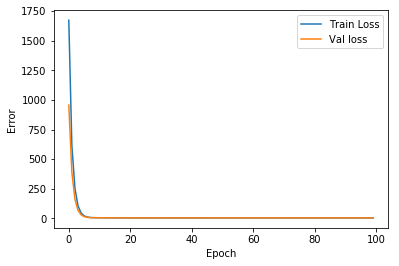

In [48]:
k = 0
train_err = []
val_err = []
for hyp in hypParSet:
    num_mixes = hyp
    model_directory = directory + '/model/num_mixes_%d' % num_mixes
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if training:
        model_FF_MDN = build_FF_MDN_model(output_dim, num_mixes, learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model_FF_MDN.fit(train_data, train_labels, epochs=Epochs, batch_size=batch_size,
                                    validation_split=0.1, verbose=0, callbacks=[PrintDot()])
        # serialize model to JSON
        model_json = model_FF_MDN.to_json()
        name = "/model %s_%s (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, rho, num_mixes)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, rho, num_mixes)
        model_FF_MDN.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, rho, num_mixes)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_FF_MDN = model_from_json(loaded_model_json, custom_objects={'MDN': MDN})
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, rho, num_mixes)
        model_FF_MDN.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model_FF_MDN.compile(loss=get_mixture_loss_func(output_dim, num_mixes),
                      optimizer=tf.train.RMSPropOptimizer(learning_rate))


## Plotting Ground-Truth vs Predictions



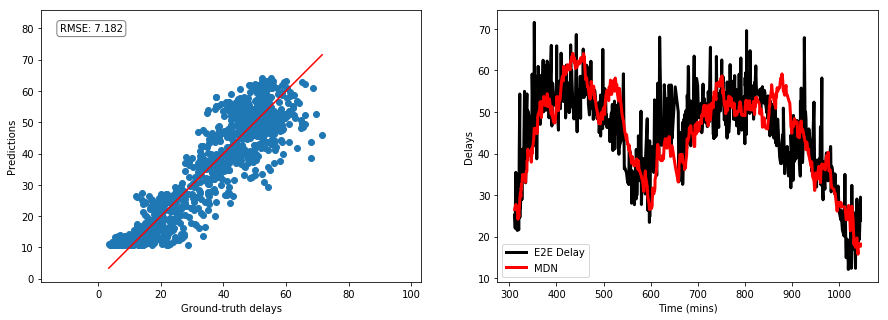

RMSE:  7.1824, Absolute Bias =  0.6195


In [49]:
    train_len = np.shape(train_data)[0]
    test_len = np.shape(test_data)[0]
#    -------------SCATTER PLOT FOR PREDICTIONS---------------------------------------------
    test_pred = model_FF_MDN.predict(test_data)
    mus = test_pred[:, :num_mixes * output_dim]
    sigs = test_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(test_pred[:, -num_mixes:])
    predictions = np.sum(mus * pis, axis=1)
    min_range, max_range = min(min(test_labels), min(predictions)), max(max(test_labels), max(predictions))
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot(121)
    plt.scatter(test_labels, predictions)
    plt.xlabel('Ground-truth delays')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim([-1, 1.2 * max_range])
    plt.ylim([-1, 1.2 * max_range])
    plt.plot([min_range, max_range], [min_range, max_range], 'r')
    RMSE = np.sqrt(mean_squared_error(test_labels, predictions))
    props = dict(boxstyle='round', facecolor='White', alpha=0.5)
    textstr = 'RMSE: %.3f' % RMSE
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
#     ------------------------------------PLOTTING A SAMPLE PATH---------------------------------------------
    samplePath_pred_params = model_FF_MDN.predict(samplePath_inp)
    mus = samplePath_pred_params[:, :num_mixes * output_dim]
    sigs = samplePath_pred_params[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(samplePath_pred_params[:, -num_mixes:])
    samplePath_predictions = np.sum(mus * pis, axis=1)
    plt.subplot(122)
    plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='E2E Delay')
    plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='MDN')
    plt.legend()
    plt.xlabel('Time (mins)')
    plt.ylabel('Delays')
    plt.show()
#     ------------------------------------Comparing the efficiency of LES and RNN_MDN model-------------------------
    AB = np.abs(np.mean(test_labels - predictions))
    RMSE = np.sqrt(mean_squared_error(test_labels, predictions))
    # MSE_LCS = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
    print("RMSE: %7.4f, Absolute Bias = %7.4f" %(RMSE, AB))

In [50]:
example = np.array([[16, 12, 13]])
example = (example - mean) / std
example_pred = model_FF_MDN.predict(example)
mus = example_pred[:, :num_mixes * output_dim]
sigs = example_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
pis = softmax(example_pred[:, -num_mixes:])
example_predictions = np.sum(mus * pis, axis=1)
example_predictions

array([53.822075], dtype=float32)

## Predicting Upperbound and Lowerbounds for the E2E Delay

predicting upperbounds ($w_{ub}$) and lowerbounds ($w_{lb}$) on a new customer's end-to-end delay ($w_{e2e}$), using the learned distribution from MDN. 

$P(w_{e2e} < w_{ub}) \geq p_{ub}$,

$P(w_{e2e} > w_{lb}) \geq p_{lb}$

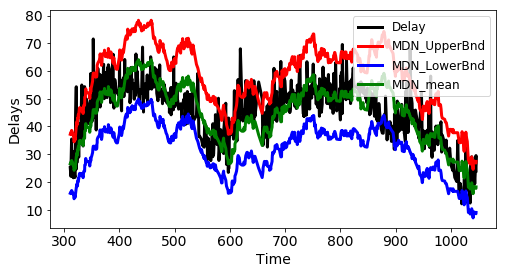

In [51]:
P_ub = 0.95
P_lb = 0.95
samplePath_upperBnd = []
samplePath_lowerBnd = []
#     ------------------------------------PLOTTING BOUNDS FOR A SAMPLE PATH---------------------------------------------
samplePath_pred_params = model_FF_MDN.predict(samplePath_inp)

for i in range(np.shape(samplePath_pred_params)[0]):
  mixCDF_ub = lambda x: mixture_CDF(x, samplePath_pred_params[i:i+1],
                                    output_dim, num_mixes) - P_ub
  mixCDF_lb = lambda x: 1 - mixture_CDF(x, samplePath_pred_params[i:i+1],
                                    output_dim, num_mixes) - P_lb
  samplePath_upperBnd.append(fsolve(mixCDF_ub, samplePath_predictions[i]))
  samplePath_lowerBnd.append(fsolve(mixCDF_lb, samplePath_predictions[i]))

fig = plt.figure(figsize=(8,4))
fsize =14
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='Delay')
# plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='0.5', lw=3., ls='--', label='LCS')
plt.plot(Ta_samp, samplePath_upperBnd, c='r', lw=3., label='MDN_UpperBnd')
plt.plot(Ta_samp, samplePath_lowerBnd, c='b', lw=3., label='MDN_LowerBnd')
plt.plot(Ta_samp, samplePath_predictions, c='g', lw=3., label='MDN_mean')
plt.legend()
plt.xlabel('Time', fontsize=fsize)
plt.ylabel('Delays', fontsize=fsize)
plt.legend(loc=1, fontsize=12)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.savefig(fig_directory + '/QL_UpLo_bounds.eps',bbox_inches='tight')

# Confidence Intervals

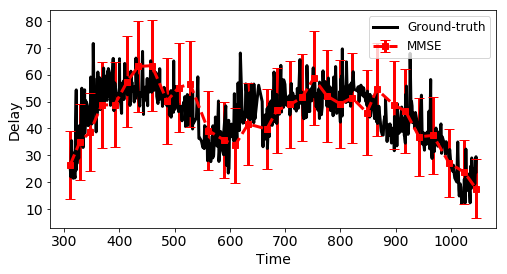

In [52]:
from scipy.optimize import fsolve
conf_level = 0.95
samplePath_confInterval = []
#     ------------------------------------PLOTTING BOUNDS FOR A SAMPLE PATH---------------------------------------------
samplePath_pred_params = model_FF_MDN.predict(samplePath_inp)
mus = samplePath_pred_params[:, :num_mixes * output_dim]
sigs = samplePath_pred_params[:, num_mixes * output_dim:2 * num_mixes * output_dim]
pis = softmax(samplePath_pred_params[:, -num_mixes:])
samplePath_predictions = np.sum(mus * pis, axis=1)
for i in range(np.shape(samplePath_pred_params)[0]):

  mixCDF_conf = lambda x: mixture_CDF(samplePath_predictions[i]+x, samplePath_pred_params[i:i+1], output_dim, num_mixes) - mixture_CDF(samplePath_predictions[i]-x, samplePath_pred_params[i:i+1],
                                    output_dim, num_mixes) - conf_level
  samplePath_confInterval.append(fsolve(mixCDF_conf, 0))
# *********************************************************************************************************
samplePath_confInterval = np.array(samplePath_confInterval)[:, 0]
fig = plt.figure(figsize=(8,4))
fsize =14
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='Ground-truth')
sampling_index = np.arange(0, len(Ta_samp), int(len(Ta_samp)/30))
plt.errorbar(Ta_samp[sampling_index], samplePath_predictions[sampling_index], yerr=samplePath_confInterval[sampling_index], marker='s',lw=3., ls='--', c='r', 
             capsize=5, label='MMSE')
plt.legend(loc=1, fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Delay', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(fig_directory + '/confInterval.eps',bbox_inches='tight')

## Theoretical Results


In [0]:
def QL_calculate(QL, mean_Ts, N):
    """Calculates queue lengths at each stage when the customer reaches that stage."""
    N_stage = len(QL)
    w = np.zeros(N_stage)
    for i in range(1, N_stage):
      w[i-1] = (1+QL[i-1])*mean_Ts[i-1]/N[i-1] + mean_Ts[i-1]
      QL[i] = max(0, QL[i]+QL[i-1]+N[i-1]-np.floor(N[i]*w[i-1]/mean_Ts[i]))
      for j in range(i, N_stage-1):
        QL[j+1] = max(0, QL[j+1]+np.floor(N[j]*w[i]/mean_Ts[j])-np.floor(N[j+1]*w[i]/mean_Ts[j+1]))

    return QL

In [0]:
sim = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/sim_6_12_13.csv'
                        , delimiter=',')  # without QLs
example = np.array([6,12,13])
QL = QL_calculate(example, mean_Ts, N)
E_d_tot = 0
var_d_tot = 0
for i in range(N_stage):
  E_d_tot = (QL[i]+1)*mean_Ts[i]/N[i] + E_d_tot + mean_Ts[i]
  var_d_tot = (QL[i]+1)*var_Ts[i]/(N[i]**2) + var_d_tot + var_Ts[i]


## E2E Delay Distribution Prediction Examples  

In [0]:
from scipy.optimize import minimize_scalar
def Delay_upbnd_prob(QL, mean_Ts, N, d_th):
    f = lambda theta: MGF_delay(QL, mean_Ts, N, d_th, theta)
    res = minimize_scalar(f, bounds=(0, np.min(np.divide(1.0,mean_Ts))), method='bounded')
    theta = res.x
    upbnd = MGF_delay(QL, mean_Ts, N, d_th, theta)
    return upbnd
  
def MGF_delay(QL, mean_Ts, N, d_th, theta):
    mgf = 1.0
    for i in range(0, N_stage):
      mgf = mgf * (1-theta*mean_Ts[i]/N[i])**(-(QL[i]+1)) / (1-theta*mean_Ts[i])
    mgf = mgf * np.exp(-theta*d_th)
    return mgf

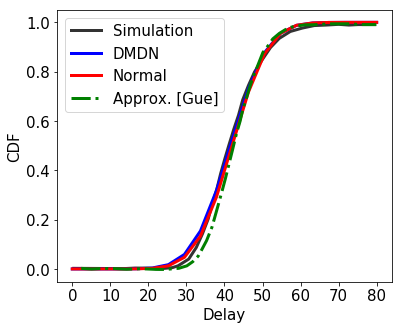

In [56]:
example = np.array([[6, 12, 13]])
example = (example - mean) / std
example_pred_params = model_FF_MDN.predict(example)
mus = example_pred_params[:, :num_mixes * output_dim]
sigs = example_pred_params[:, num_mixes * output_dim:2 * num_mixes * output_dim]
pis = softmax(example_pred_params[:, -num_mixes:])
range_plot, pdf, example_prediction = mixture_density(example_pred_params, output_dim, num_mixes)
d_th_range = np.linspace(0,80,20)
Delay_upbnd = []

for d_th in d_th_range:
  Delay_upbnd.append(Delay_upbnd_prob(QL, mean_Ts, N, d_th))
sim_cdf = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/sim_CDF_6_12_13.csv'
                        , delimiter=',')  # without QLs
approx_cdf = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/approx_CDF_6_12_13.csv'
                        , delimiter=',')  # without QLs

fig = plt.figure(figsize=(6,5))
fsize =15
plt.plot(sim_cdf[:, 0],  sim_cdf[:, 1],'0.2', label='Simulation', lw=3.0)
plt.plot(d_th_range, mixture_CDF(d_th_range, example_pred_params, output_dim, num_mixes), '-b', label='DMDN', lw=3)
plt.plot(d_th_range, norm.cdf(d_th_range, E_d_tot, np.sqrt(var_d_tot)) , '-r', label='Normal', lw=3.0)
plt.plot(approx_cdf[:, 0],  approx_cdf[:, 1],'-.g', label='Approx. [Gue]', lw=3.0)
plt.xlabel('Delay', fontsize=fsize)
plt.ylabel('CDF', fontsize=fsize)
plt.legend(loc=2, fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.savefig(fig_directory + '/CDF_tandem.eps',bbox_inches='tight')
# plt.savefig(fig_directory + '/CDF_tandem_mdn.png',bbox_inches='tight')
# ********************************

##Q-Q Plot

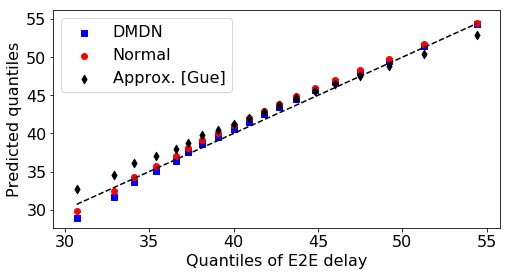

In [57]:
fig = plt.figure(figsize=(8,4))
fsize =16
sim_cdf = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/QQ_sim_6_12_13.csv'
                        , delimiter=',')  # without QLs

approx_cdf = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/QQ_approx_6_12_13.csv'
                        , delimiter=',')  # without QLs
plt.scatter(sim_cdf[:, 0], mixture_CDF_inv(sim_cdf[:, 1], example_pred_params, output_dim, num_mixes),c='b',marker='s', label='DMDN')
plt.plot(sim_cdf[:, 0], sim_cdf[:, 0], '--k')
plt.scatter(sim_cdf[:, 0], norm.ppf(sim_cdf[:, 1], E_d_tot, np.sqrt(var_d_tot)) , c='r', label='Normal')
plt.scatter(sim_cdf[:, 0],  approx_cdf[:, 0],c='k',marker='d',label='Approx. [Gue]')
plt.xlabel('Quantiles of E2E delay', fontsize=fsize)
plt.ylabel('Predicted quantiles', fontsize=fsize)
plt.legend(loc=2, fontsize=fsize)
# plt.yscale('log')
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.savefig(fig_directory + '/QQ_tandem.eps',bbox_inches='tight')

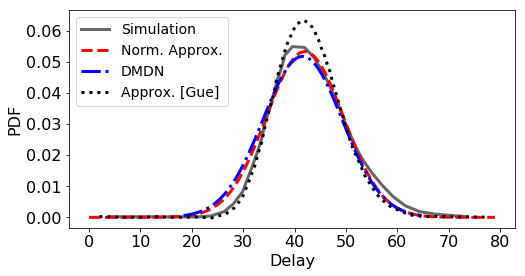

In [64]:
# **********************************************PDF*******************************************
sim = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/sim_6_12_13.csv'
                        , delimiter=',')  # without QLs
approx = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/MultiStage_QLBased/approx_6_12_13.csv'
                        , delimiter=',')  # without QLs
fig = plt.figure(figsize=(8,4))
plt.plot(sim[:, 0], sim[:, 1],'.4', label='Simulation', lw=3)
plt.plot(np.arange(80), norm.pdf(np.arange(80), E_d_tot, np.sqrt(var_d_tot)) , '--r', label='Norm. Approx.', lw=3)
plt.plot(range_plot, pdf,'-.b', label='DMDN', lw=3)
plt.plot(approx[:, 0], approx[:, 1],':k',label='Approx. [Gue]', lw=3)

fsize =16
plt.legend(loc=2, fontsize=14)
plt.xlabel('Delay', fontsize=fsize)
plt.ylabel('PDF', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.savefig(fig_directory + '/PDF_tandem.eps',bbox_inches='tight')